# DATASET
Dataset contains 6 tile  with different images
## LEGEND
the labels are:
- Building (#3C1098)
- Land (#8429F6)
- Road (#6EC1E4)
- Vegetation (#FEDD3A)
- Water (#E2A929)
- Unlabeled (#9B9B9B)

they are encoded in exadecimal 
### SOURCE
from: https://www.kaggle.com/humansintheloop/semantic-segmentation-of-aerial-imagery
'''

In [6]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [7]:
import tensorflow as tf
print(tf.__version__)

2.16.1


In [8]:
PATH  = "/Users/simoneboesso/Desktop/RemoteSensing/Semantic segmentation dataset/"

In [9]:
from SemanticSegmentation_scripts.PatchesGenerator import PatchesGenerator
PATCH_GENERATOR = PatchesGenerator(256,PATH)
PATCH_GENERATOR.crop_image_creating()
PATCH_GENERATOR.crop_mask_creating()

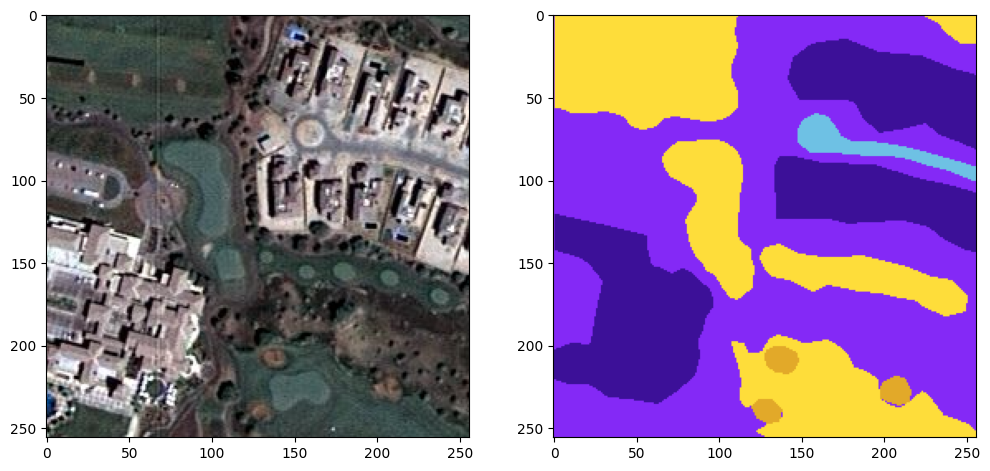

In [10]:
PATCH_GENERATOR.check()

In [11]:
from SemanticSegmentation_scripts.HEX_to_RGB import HEX_to_RGB,RGB_to_2DLabels

In [12]:
RGB_CONVERTOR = HEX_to_RGB()
HEXLabels = ["#3C1098", "#8429F6", "#6EC1E4", "#FEDD3A", "#E2A929","#9B9B9B"]
LabelsList = []
for el in HEXLabels:
    LabelsList.append(RGB_CONVERTOR.convert(el))

In [13]:
LabelsList

[array([ 60,  16, 152]),
 array([132,  41, 246]),
 array([110, 193, 228]),
 array([254, 221,  58]),
 array([226, 169,  41]),
 array([155, 155, 155])]

In [14]:
LABEL_CONVERTOR = RGB_to_2DLabels(LabelsList)
mask_dataset = PATCH_GENERATOR.mask_dataset
image_dataset = PATCH_GENERATOR.image_dataset

In [15]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = LABEL_CONVERTOR.convert(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)

In [16]:
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


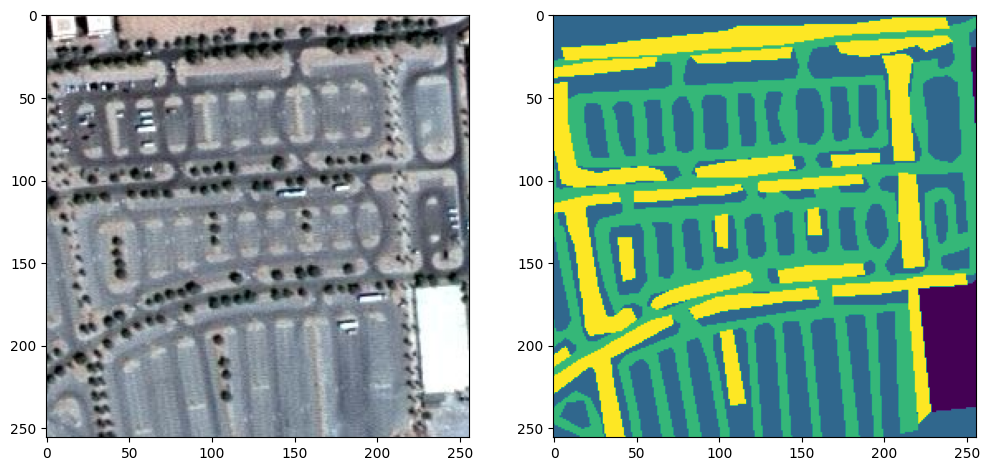

In [17]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

# Modelling section

In [18]:
n_classes = len(np.unique(labels))
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

## NEXT STEPS:

- Grid search for hyperparameter tuning following university procedure;
- review U-net concepts
- compare with other pretrained models


# Choosing hyperparameters

1. Check initial Loss (Turn off weight decay, sanity check loss at initialization)
2. Overfit a small sample (try to train to 100% training accuracy on a small sample of training data, approx. 5-10 minibatches)
    1. Fiddle with architecture, learning rate, weight initialization;
    2. some common problems:
        1. Loss is not going down: LR too low, or bad initialization;
        2. Loss explodes to Inf or Nan: LR too high, bad initialization
3. Use all the training data, turn on small weight decay, find the learning rate that makes the loss drop significantly  withing 100 iterations ( use the same architecture obtained in the previous step);
    1. good learning rates to try: 1e-1, 1e-2, 1e-3, 1e-4
4. choose few values of learning rate and weight decay around what worked for the previous step and then train these few models for 1-5 epochs
    1. good weight decay to try: 1e-4, 1e-5, 0
5. Pick the best models from Step 4, train them for longer 10-20 epochs WITHOUT learning rate decay.
6. Measure their performances using loss and accuracy curves
7. Go back to step 5 if needed (refine grid search)

In [20]:
import wandb
#wandb.login()
#!wandb login() 
# https://docs.wandb.ai/quickstart

In [21]:
_, sample_imgs, y_, sample_labels = train_test_split(X_train, y_train, test_size = 0.005, random_state = 42)

In [22]:
from SemanticSegmentation_scripts.Multi_unet_model import multi_unet_model, jacard_coef  

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]



1. Check initial loss

In [ ]:
model = multi_unet_model()
model.compile(optimizer='adam', loss=sm.losses.CategoricalFocalLoss(), metrics=["accuracy"])
history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=1, 
                    shuffle=False)

2. Overfit a small sample

In [ ]:
sample_imgs.shape

In [ ]:
model = multi_unet_model()
model.compile(optimizer='adam', loss=sm.losses.CategoricalFocalLoss(), metrics=["accuracy"])
history2 = model.fit(sample_imgs, sample_labels, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=300, 
                    shuffle=False)

In [ ]:
history = history2
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training  loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

3. Grid-Search (for 100 iterations)

In [ ]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

In [ ]:
X_train.shape

In [32]:
import math
# dividing by 2 due to the cv
num_samples = 835
batch_size = 32

# Calculate the number of epochs to reach the total iterations
batches_per_epoch = math.ceil(num_samples / batch_size) # this is equal to the number of iteration in a epoch
batches_per_epoch 

27

In [33]:
total_iterations = 100
epochs = math.ceil(total_iterations / batches_per_epoch)
epochs

4

In [27]:
# Function used for Grid-search
def define_model(optimizer = "adam"):
    model = multi_unet_model()
    model.compile(loss=sm.losses.CategoricalFocalLoss(), metrics=['accuracy'])
    return model


In [28]:
# Initialize W&B
import wandb
wandb.init(project="FirstGridSearch")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: boesso-simone (simboex). Use `wandb login --relogin` to force relogin


We can't use keras wrapper and grid search here due to shape constraints.

In fact, it is thought for 1D input/output.

We need to do sth else here!
https://adriangb.com/scikeras/stable/notebooks/DataTransformers.html

In [ ]:
#optimizer = ['Adam']
#param_grid = dict(optimizer=["adam"],
                  )
#model = KerasClassifier(model= define_model, optimizer="adam", epochs= 6,input_shape=(256, 256, 3),num_classes=6)

#grid = GridSearchCV(estimator=model, param_grid=param_grid,  verbose = 1, n_jobs=1, cv=2, error_score='raise')

#grid_result = grid.fit(X_train, y_train) 

In [ ]:
# summarize results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
 #   print("Mean = %f (std=%f) with: %r" % (mean, stdev, param))

Then, We generate a split and then with a method we define the grid.

Manually, the model is fit and then tested for evaluation!

In [29]:
from sklearn.model_selection import ParameterGrid
param_grid = {
    'optimizer': ["adam"],
    #'kernel_size': [3, 5],
    #'epochs': [5, 10],
    #'batch_size': [16, 32]
}
list(ParameterGrid(param_grid))

[{'optimizer': 'adam'}]

In [31]:
from sklearn.model_selection import ParameterGrid

X_train_grid, X_test_grid, y_train_grid, y_test_grid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

X_train_grid.shape

(835, 256, 256, 3)

In [ ]:


param_grid = {
    'optimizer': ["adam"],
    #'kernel_size': [3, 5],
    #'epochs': [5, 10],
    #'batch_size': [16, 32]
}

results = []

for params in ParameterGrid(param_grid):
    print("Training with params:", params)
    model = define_model(optimizer=param_grid['optimizer'])
    
    # Fit the model
    model.fit(X_train_grid, y_train_grid, epochs=4, batch_size=32, verbose=1)
    
    # Evaluate the model
    score = model.evaluate(X_test_grid, y_test_grid, verbose=0)
    results.append({
        'params': params,
        'score': score
    })
    
    # Print results
for result in results:
    print("Parameters:", result['params'])
    print("Score:", result['score'])
